# BERT TRANSFORMER, BINARY AND MULTICLASS TASKS FOR CYBERBULLYING DETECTION

by ChunkDevs (Group 1)

Transformer are the standard architecture for building large language models, thanks to their mechanism called self-attention, allows to build contextual representations of a word’s meaning that
integrate information from surrounding words, helping the model learn how words
relate to each other over large spans of text

In this notebook we will try to implement one of the most common transformer encoder-only model: **BERT**. 
In the first part, we will  use `Bert-base-uncased` for binary and classification tasks with the dataset with only english tweets. Secondly, `bert_multilingual-base-uncased` will be implemented with the multilanguage dataset. 

After drawing the learning/ accuracy curves, the models will be trained directly using all the dev-set, then the results will be shown and compared.  

In [44]:
import sys
import os

directory = os.getcwd().split(os.path.sep)
root_index = directory.index("V_HLT")
root_path = os.path.sep.join(directory[:root_index+1])

sys.path.append(root_path)

import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from IPython.display import display, HTML

from _chunkdevs.models import ModelHandler, ChunkDevs_Transformer, Build_Handle
from _chunkdevs.data_functions import *

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

In [45]:
dev_path = os.path.join(root_path, "data", "processed", "english_tweets_dev_set.csv")
dev = pd.read_csv(dev_path, encoding="utf-8", skipinitialspace=True)

test_path = os.path.join(root_path, "data", "processed", "english_tweets_test_set.csv")
test = pd.read_csv(test_path, encoding="utf-8", skipinitialspace=True)

model_path = os.path.join(root_path, "outputs", "models")

## MAIN VARIABLES

<div style="font-size: 16px">

Just like the other notebooks, the value of 42 for the `RANDOM_STATE` and 0.2 for `VAL_SIZE` have been chosen in order to guarantee the reproducibilty of the procedure.  

For the `BATCH_SIZE` variable, we opted for a value of 16 examples for batch, which allows to reduce the amount of data that are allocated in the memory and consequentially save resources. 

`LEARNING_RATE` and `EPS` are the hyperparameters that need to be specified for the training of the Bert model. We decided to choose the most common values that are usually used for define the learning process.

Considering the `EPOCHS` hyperparameter, it necessary to clarify that the number of the epochs has been selected after the representation of the learning and accuracy curves in order to avoid a possible overfitting situation 
</div>

In [46]:
RANDOM_STATE = 42
VAL_SIZE = 0.2
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5
EPS = 1e-8

# Labels used for classification reports and confusion matrixes
labels_name_bin = ["not_cyberbullying", "cyberbullying"]
labels_name_multi = ["age", "ethnicity", "gender", "not_cyberbullying", "other_cyberbullying", "religion"]

<div style="font-size: 16px">

For implementing the transformers, we decided to use our class `ChunkDevs_Transformer` from our library, which uses PyTorch module for building and training Transformer-based models (BERT , BERT-multilingual or RoBERTa) for text classification.

This are the attributes needed:

- `model_type` : The type of Transformer model ("bert", "bert_multilingual" or "roberta").
- `sequences_length` The maximum length of input sequences. We always used 128, whic is a very common value
- `classes` : The number of classes for classification. 2 for binary classification, 6 for multiclass
- `random_state`: The random seed for reproducibility. (We always used 42)
- `device` : The device to run the model on (CPU or GPU).

This are the method available:

- `set_seed`: Set seed for reproducibility across runs.
- `forward`: Forward pass of the model, this method has been used during the training.
- `train_model`: Train the Transformer model, using the **cross entropy loss** as loss criteria
- `evaluate_model`: Evaluate the Transformer model on validation.
- `predict`: Make predictions using the trained Transformer model.
- `save_results`: Save evaluation results (accuracy and classification report) to a file.
- `train_val_curves`: Draw the loss/ accurracy curves of the transformer

</div>

# ENGLISH TWEETS CLASSIFICATION

## BINARY TASK

### DATA LOADING AND SPLITTING 

Using the processed text in the dev set and the raw tweets in the test set.

In [4]:
X_dev_bin = dev['tweet_text_cleaned'].values
y_dev_bin = dev['cyberbullying_type_bin'].values
X_test_bin = test['tweet_text'].values
y_test_bin = test['cyberbullying_type_bin'].values

X_train, X_val, y_train, y_val = train_test_split(X_dev_bin, y_dev_bin, test_size=VAL_SIZE) 

<div style="font-size: 16px">
    
In this phase, we initialize a pretrained Bert-base-uncased model using the `ChunkDevs_Tranformer` class of our library. 
This class defines:
- The **pretrained model**,
- The **pretrained tokenizer**,
- The **dropout** (always 0.2)
- The classifier with `nn.Linear` of the pyTorch library.

Secondly, the dataset has been prepared in order to have a tokenized and suitable input for the transformer, using our **`Build_Handle`** class, which has infat the job of building a correct dataset for tranformer models. 

This class takes the texts, the labels, the tokenizer and the `max_length` hyperparameters to transform the labels to a `torch.tensor` and initialize the tokenizer, always  with `padding = "max_length"`, `add_special_tokens = True`, `truncation = True ` hyperparameter set. 
After that, it creates the dictionary containing the tokenized input IDs, attention masks, and labels.

Finally, with the `DataLoader` method from `torch.utils.data`, which divides the input in a series of batch of dimension given by the `BATCH_SIZE` hyperparameter, we have a suitable input for our models, the Adam optimizer and the train scheduler are defined and it is possible to proceed.

</div>

### PLOTTING LEARNING AND ACCURACY CURVES

<div style="font-size: 16px">
    
In order to choose the right number of epochs, we use the `train_val_curves` method of our class to train and validate the model.

The dataset has been splitted into training and validation set using an hold out approach (80/20) and prepared again with `Build_Handle` and `DataLoader`.

For each epoch, the method calculates the losses and the accuracies during the train and the validation processes, stores them in two lists and then draws the plots. This method, especially with an high number of epochs can **take a lot of time**. For this reason,

</div>

PLOTTING:: 131440it [28:57, 75.64it/s]                                          1.66it/s]


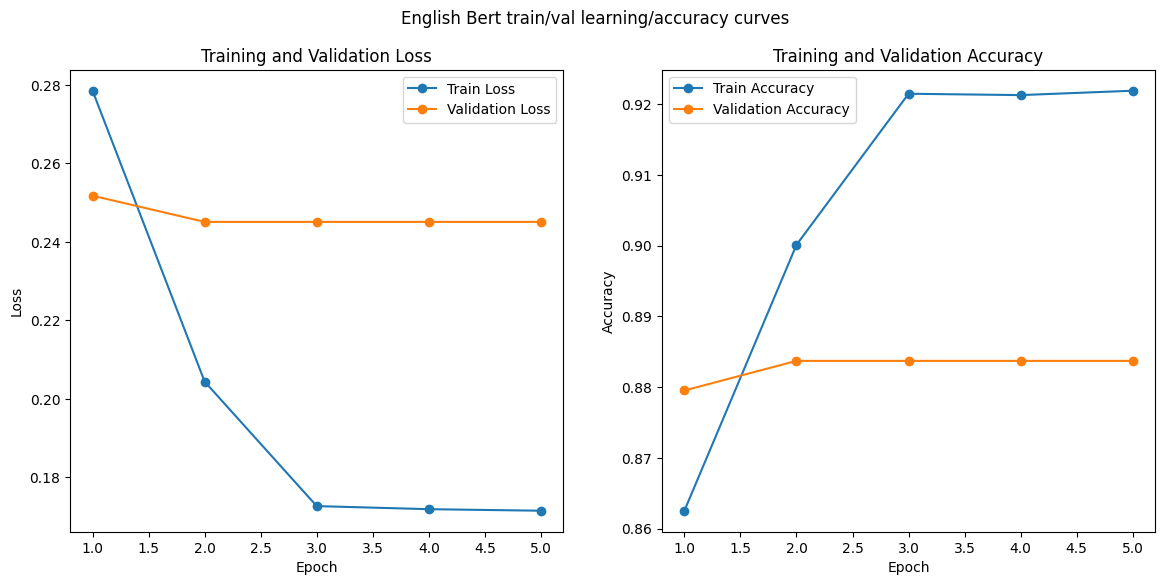

In [5]:
bert = ChunkDevs_Transformer("bert", sequences_length=128, classes=2, random_state=RANDOM_STATE)
plot_epochs = 5
plot_title = "English Bert train/val learning/accuracy curves"

build_train = Build_Handle(X_train, y_train, tokenizer=bert.tokenizer)
build_val = Build_Handle(X_val, y_val, tokenizer=bert.tokenizer)

dataloader_train = DataLoader(build_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(build_val, batch_size=BATCH_SIZE)

optimizer = AdamW(bert.parameters(), lr=LEARNING_RATE, eps=EPS)
steps = len(dataloader_train) * 2
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=steps)

# bert.train_val_curves(train_dataloader=dataloader_train, val_dataloader=dataloader_val, optimizer=optimizer, scheduler=scheduler, plot_epochs=plot_epochs, title=plot_title)

<div style="font-size: 20px">

Looking at the plot, we can see that that the model **slightly overfits** in the second epoch. However, we still choosed 2 as the definitive number of epoch. A possible alternative would be to reduce the complexity of the model 

<br>
<br>
</div>

### FINAL RETRAIN AND TESTING PHASE

<div style="font-size: 16px">
    
In this phase we initialize and train the model using all the dev set in order to use all the available data, and then the model does a blind prediction on the test set with the `predict_model` and compares the final prediction with the test set label.

</div>

In [6]:
bert = ChunkDevs_Transformer("bert", sequences_length=128, classes=2, random_state=RANDOM_STATE)

build_dev = Build_Handle(X_dev_bin, y_dev_bin, tokenizer=bert.tokenizer)
build_test = Build_Handle(X_test_bin, y_test_bin, tokenizer=bert.tokenizer)

dataloader_dev = DataLoader(build_dev, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(build_test, batch_size=BATCH_SIZE)

optimizer = AdamW(bert.parameters(), lr=LEARNING_RATE, eps=EPS)
steps = len(dataloader_dev) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=steps)

<div style="font-size: 16px">
<br>
    
The `train__model` method implements the learning phase of the transformer, where the model calculates and returns the average loss for every epoch. 

The loss type that has been chosen is the *cross entropy* loss function:

$$ L_{CE}(\hat{y}, y) = -\log p(y|x) = -[y \log \hat{y} + (1 - y) \log (1 - \hat{y})] $$
Where $(y)$ is the true probability distribution and $(\hat{y})$ is our estimated distribution

</div>

In [7]:
bert.train_model(dataloader=dataloader_dev, optimizer=optimizer, scheduler=scheduler, num_epochs=EPOCHS)

Training Epoch 1/2: : 26272it [06:40, 65.66it/s]                                                    5.39it/s]


Train Loss for Epoch 1: 0.2733


Training Epoch 2/2: : 26272it [06:44, 64.95it/s]                                                    4.72it/s]

Train Loss for Epoch 2: 0.1998
Trained Completed.


In [8]:
bert_preds = bert.predict(dataloader_test)

PREDICTING:: 2928it [00:15, 192.51it/s]                                                             3.60it/s]

Prediction completed


In [9]:
report = classification_report(y_test_bin, bert_preds, target_names=labels_name_bin)
print('Classification Report:\n', report)

Classification Report:
                    precision    recall  f1-score   support

not_cyberbullying       0.68      0.54      0.61       487
    cyberbullying       0.91      0.95      0.93      2435

         accuracy                           0.88      2922
        macro avg       0.80      0.75      0.77      2922
     weighted avg       0.87      0.88      0.88      2922



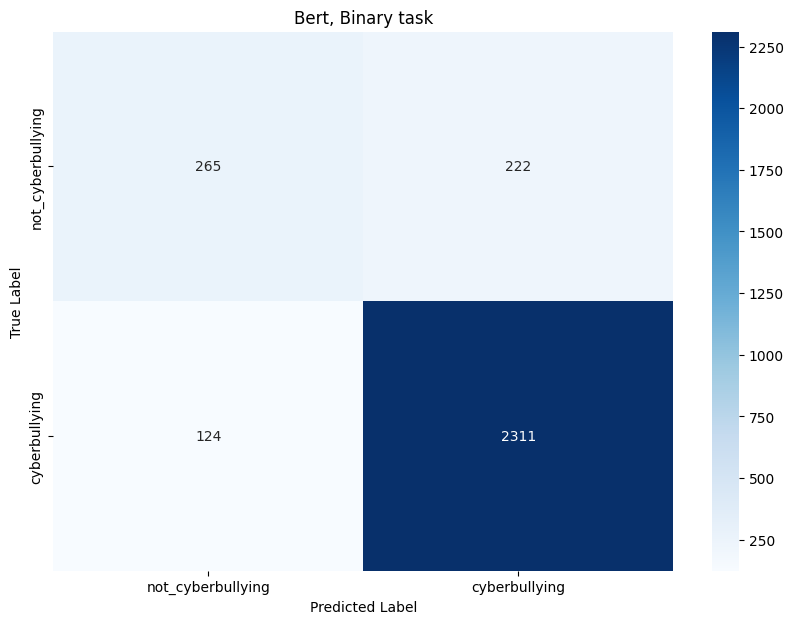

In [10]:
cm = confusion_matrix(y_test_bin, bert_preds)

cm_df = pd.DataFrame(cm, index=labels_name_bin, columns=labels_name_bin)

# Visualizza la matrice di confusione usando Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Bert, Binary task')
plt.show()

<div style="font-size: 20px;">

As we can see from the report and the confusion matrix, Bert is the model with the highest precision for class 0, correctly classifying the majority of the not cyberbullying tweets, but it has a lower recall and f1 scored compared to Roberta.  

Moreover, even this model suffers from the **false flagging** problem. Infact, it almost classifies the **45% of the not_cyberbullyng tweets as harmful texts**.  

<br>
<br>
</div>


#### SAVING THE MODEL AND THE RESULTS

Saving the model and the results to the appropriate folder

In [13]:
handler = ModelHandler(model_path)
handler.save_model(model = bert, name= "Bert_binary")

------------------------------------------------------------------------------------
| Save model 'Bert_binary' to /home/m.sanna21/V_HLT/outputs/models/Bert_binary.pkl |
------------------------------------------------------------------------------------


In [15]:
report_path = os.path.join(root_path, "outputs", "reports", "Bert_english_binary")
bert.save_results(dataloader_test, path = report_path, labels_name=labels_name_bin)

EVALUATION:: 2928it [00:06, 474.98it/s]                                                             3.60it/s]

-----------------------------------------------------------------------------
| Report saved to /home/m.sanna21/V_HLT/outputs/reports/Bert_english_binary |
-----------------------------------------------------------------------------


## MULTI-CLASS TASK

<div style="font-size: 16px;">

In this phase the model will be used for classyfying all the 6 classes and distinguish among the different cyberbullying types. The procedure will be the same as before. 

</div>

### DATA LOADING  

In [47]:
X_dev_multi = dev['tweet_text_cleaned'].values
y_dev_multi = dev['cyberbullying_type_multi'].values
X_test_multi = test['tweet_text'].values
y_test_multi = test['cyberbullying_type_multi'].values

### FINAL RETRAIN AND TESTING PHASE

In [48]:
bert = ChunkDevs_Transformer("bert", sequences_length=128, classes=6, random_state=RANDOM_STATE)

build_dev = Build_Handle(X_dev_multi, y_dev_multi, tokenizer=bert.tokenizer)
build_test = Build_Handle(X_test_multi, y_test_multi, tokenizer=bert.tokenizer)

dataloader_dev = DataLoader(build_dev, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(build_test, batch_size=BATCH_SIZE)

optimizer = AdamW(bert.parameters(), lr=LEARNING_RATE, eps=EPS)
steps = len(dataloader_dev) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=steps)

In [6]:
bert.train_model(dataloader=dataloader_dev, optimizer=optimizer, scheduler=scheduler, num_epochs=EPOCHS)

Training Epoch 1/2: : 26272it [03:14, 134.94it/s]                                                   5.32it/s]


Train Loss for Epoch 1: 0.4817


Training Epoch 2/2: : 26272it [03:02, 143.86it/s]                                                   4.12it/s]

Train Loss for Epoch 2: 0.2906
Trained Completed.


In [7]:
bert_preds = bert.predict(dataloader_test)

PREDICTING:: 2928it [00:07, 370.28it/s]                                                             5.93it/s]

Prediction completed


In [8]:
report = classification_report(y_test_multi, bert_preds, target_names=labels_name_multi)
print('Classification Report:\n', report)

Classification Report:
                      precision    recall  f1-score   support

                age       0.99      0.98      0.98       487
          ethnicity       0.98      0.98      0.98       487
             gender       0.91      0.87      0.89       487
  not_cyberbullying       0.67      0.64      0.65       487
other_cyberbullying       0.67      0.74      0.70       487
           religion       0.96      0.96      0.96       487

           accuracy                           0.86      2922
          macro avg       0.86      0.86      0.86      2922
       weighted avg       0.86      0.86      0.86      2922



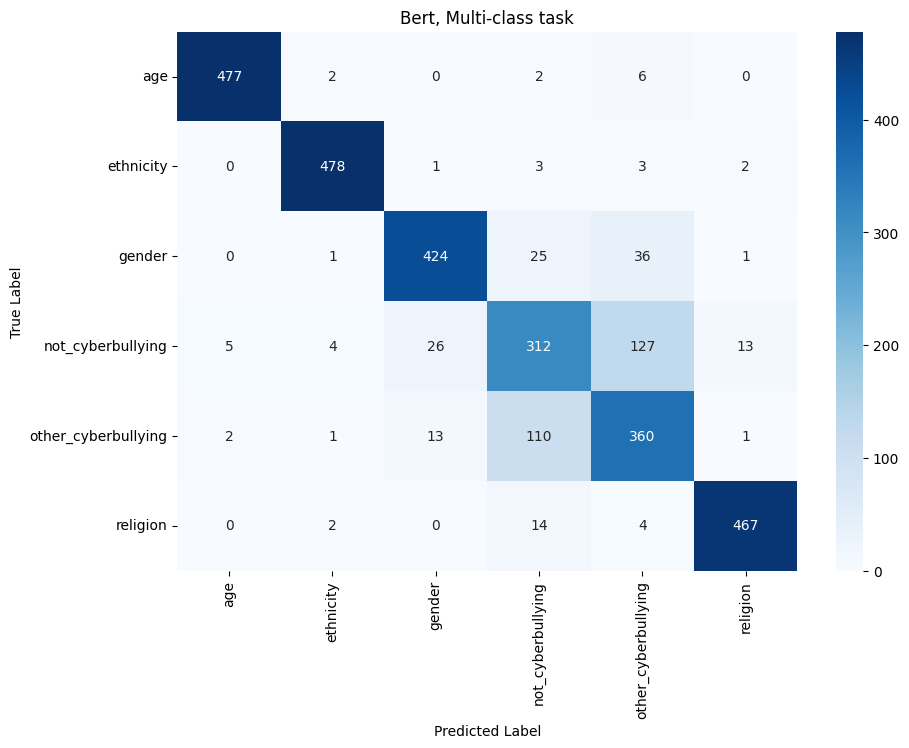

In [9]:
cm = confusion_matrix(y_test_multi, bert_preds)

cm_df = pd.DataFrame(cm, index=labels_name_multi, columns=labels_name_multi)

# Visualizza la matrice di confusione usando Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Bert, Multi-class task')
plt.show()

<div style="font-size: 20px;">
<br>

Looking at the results, Bert is one of the models with the **highest accuracy** (86%), and it has the same weakness of the other models, confusing the not cyberbullying tweets with the other cyberbullying tweets

<br>
<br>
</div>

#### SAVING THE MODEL AND THE RESULTS

In [10]:
handler = ModelHandler(model_path)
handler.save_model(model = bert, name= "Bert_binary")

------------------------------------------------------------------------------------
| Save model 'Bert_binary' to /home/m.sanna21/V_HLT/outputs/models/Bert_binary.pkl |
------------------------------------------------------------------------------------


In [13]:
report_path = os.path.join(root_path, "outputs", "reports", "Bert_english_multiclass")
bert.save_results(dataloader_test, path = report_path, labels_name=labels_name_multi)

EVALUATION:: 2928it [00:06, 478.15it/s]                                                             6.47it/s]

---------------------------------------------------------------------------------
| Report saved to /home/m.sanna21/V_HLT/outputs/reports/Bert_english_multiclass |
---------------------------------------------------------------------------------


# MULTILANGUAGE CLASSIFICATION

<div style="font-size: 16px;">
    
In this part, we decided to try another version of BERT, `Bert-base-multilingual-uncased`, to classify the tweets using the multilanguage dataset. We choosed this model due to the low number of the pretrained model paramenters, which guarantee a faster training and a lower occupation of memory rosources.

We initialize the transformer using againg our class `ChunkDevs_Transformers`, setting the same architecture as the Bert base model. The trainign and testing procedure is the same as before for binary and multiclass tasks. 

</div>

In [49]:
RANDOM_STATE = 42
VAL_SIZE = 0.2
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5
EPS = 1e-8

# Labels used for classification reports and confusion matrixes
labels_name_bin = ["not_cyberbullying", "cyberbullying"]
labels_name_multi = ["age", "ethnicity", "gender", "not_cyberbullying", "other_cyberbullying", "religion"]

dev_path = os.path.join(root_path, "data", "processed", "multilanguage_dev_set.csv")
dev = pd.read_csv(dev_path, encoding="utf-8", skipinitialspace=True)

test_path = os.path.join(root_path, "data", "processed", "multilanguage_test_set.csv")
test = pd.read_csv(test_path, encoding="utf-8", skipinitialspace=True)

model_path = os.path.join(root_path, "outputs", "models")
report_path = os.path.join(root_path, "V_HLT", "outputs", "reports")

## BINARY TASK

### DATA LOADING AND SPLITTING 

In [51]:
X_dev_bin = dev['tweet_text_cleaned'].values
y_dev_bin = dev['cyberbullying_type_bin'].values
X_test_bin = test['tweet_text'].values
y_test_bin = test['cyberbullying_type_bin'].values

X_train, X_val, y_train, y_val = train_test_split(X_dev_bin, y_dev_bin, test_size=VAL_SIZE) 

### PLOTTING LEARNING AND ACCURACY CURVES

PLOTTING:: 165600it [17:27, 158.16it/s]                                         0.59it/s]


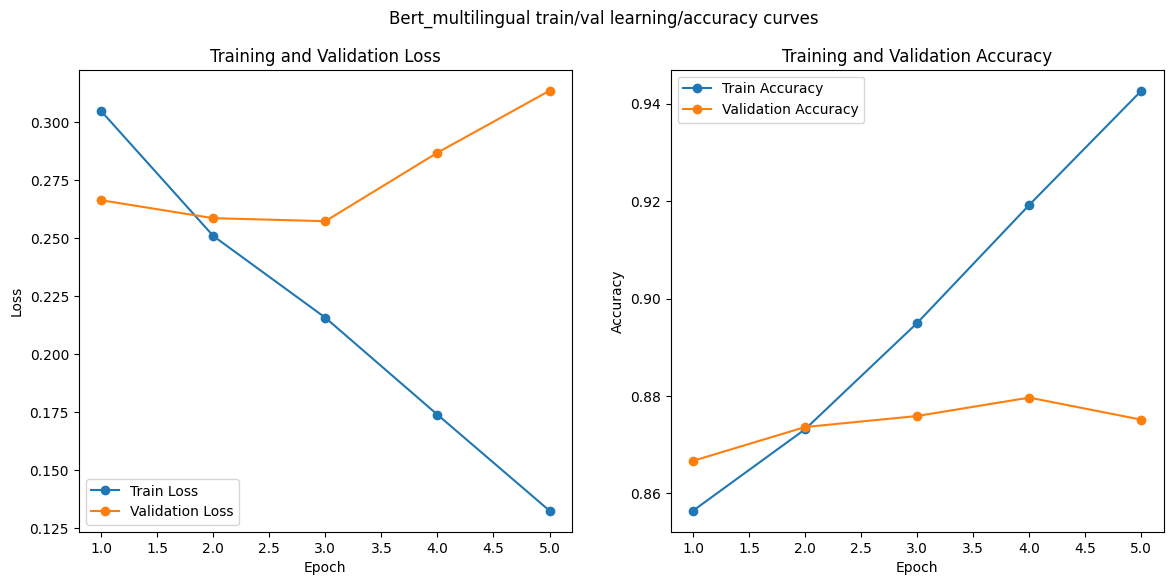

In [54]:
bert_plot_multi = ChunkDevs_Transformer("bert_multilingual", sequences_length=128, classes=2, random_state=RANDOM_STATE)
plot_epochs = 5
plot_title = "Bert_multilingual train/val learning/accuracy curves"

build_train = Build_Handle(X_train, y_train, tokenizer=bert.tokenizer)
build_val = Build_Handle(X_val, y_val, tokenizer=bert.tokenizer)

dataloader_train = DataLoader(build_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(build_val, batch_size=BATCH_SIZE)

optimizer = AdamW(bert_plot_multi.parameters(), lr=LEARNING_RATE, eps=EPS)
steps = len(dataloader_train) * 5
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=steps)


bert_plot_multi.train_val_curves(train_dataloader=dataloader_train, val_dataloader=dataloader_val, optimizer=optimizer, scheduler=scheduler, plot_epochs=plot_epochs, title=plot_title)

<div style="font-size: 20px">

Looking at the plot, we can see that that the model **slightly overfits** in the second epoch. However, we still choosed 2 as the definitive number of epoch. A possible alternative would be to reduce the complexity of the model 

<br>
<br>
</div>

### FINAL RETRAIN AND TESTING PHASE

In [21]:
bert_multi = ChunkDevs_Transformer("bert_multilingual", sequences_length=128, classes=2, random_state=RANDOM_STATE)

build_dev = Build_Handle(X_dev_bin, y_dev_bin, tokenizer=bert_multi.tokenizer)
build_test = Build_Handle(X_test_bin, y_test_bin, tokenizer=bert_multi.tokenizer)

dataloader_dev = DataLoader(build_dev, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(build_test, batch_size=BATCH_SIZE)

optimizer = AdamW(bert_multi.parameters(), lr=LEARNING_RATE, eps=EPS)
steps = len(dataloader_dev) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=steps)

In [22]:
bert_multi.train_model(dataloader=dataloader_dev, optimizer=optimizer, scheduler=scheduler, num_epochs=EPOCHS)

Training Epoch 1/2: : 33120it [04:14, 130.05it/s]                                                   1.86it/s]


Train Loss for Epoch 1: 0.2633


Training Epoch 2/2: : 33120it [03:59, 138.45it/s]                                                   8.62it/s]

Train Loss for Epoch 2: 0.2038
Trained Completed.


In [23]:
bert_multi_preds = bert_multi.predict(dataloader_test)
report = classification_report(y_test_bin, bert_multi_preds, target_names = labels_name_bin)
print(report)

PREDICTING:: 100%|█████████████████████████████████████████████| 3744/3744 [00:09<00:00, 382.80it/s]

Prediction completed
                   precision    recall  f1-score   support

not_cyberbullying       0.78      0.49      0.60       624
    cyberbullying       0.91      0.97      0.94      3120

         accuracy                           0.89      3744
        macro avg       0.84      0.73      0.77      3744
     weighted avg       0.88      0.89      0.88      3744



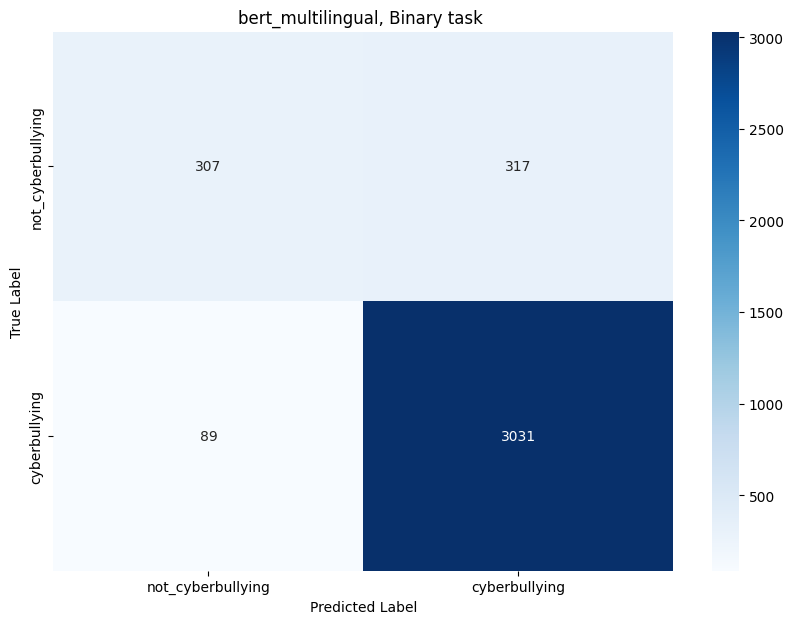

In [24]:
cm = confusion_matrix(y_test_bin, bert_multi_preds)

cm_df = pd.DataFrame(cm, index=labels_name_bin, columns=labels_name_bin)

# Visualizza la matrice di confusione usando Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('bert_multilingual, Binary task ')
plt.show()

<div style="font-size: 20px">

Looking at the results, this model has an **high value of precision**, but its low recall value leaves a large number of not cyberbullying tweets uncorrectly classified 

<br>
<br>
</div>

#### SAVING THE MODEL AND THE RESULTS

In [25]:
report_path = os.path.join(root_path, "outputs", "reports", "Bert Multilingual binary results")
bert_multi.save_results(dataloader_test, path = report_path, labels_name=labels_name_bin)

EVALUATION:: 100%|█████████████████████████████████████████████| 3744/3744 [00:07<00:00, 471.82it/s]

------------------------------------------------------------------------------------------
| Report saved to /home/m.sanna21/V_HLT/outputs/reports/Bert Multilingual binary results |
------------------------------------------------------------------------------------------


In [26]:
handler = ModelHandler(model_path)
handler.save_model(model = bert_multi, name= "bert_multilingual_binary")

--------------------------------------------------------------------------------------------------------------
| Save model 'bert_multilingual_binary' to /home/m.sanna21/V_HLT/outputs/models/bert_multilingual_binary.pkl |
--------------------------------------------------------------------------------------------------------------


## MULTICLASS TASK

### DATA LOADING

In [27]:
X_dev = dev['tweet_text_cleaned'].values
y_dev = dev['cyberbullying_type_multi'].values
X_test = test['tweet_text'].values
y_test = test['cyberbullying_type_multi'].values

### FINAL RETRAIN AND TESTING PHASE

In [28]:
bert_multi = ChunkDevs_Transformer("bert_multilingual", sequences_length=128, classes=6, random_state=RANDOM_STATE)

build_dev = Build_Handle(X_dev, y_dev, tokenizer=bert_multi.tokenizer)
build_test = Build_Handle(X_test, y_test, tokenizer=bert_multi.tokenizer)

dataloader_dev = DataLoader(build_dev, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(build_test, batch_size=BATCH_SIZE)

optimizer = AdamW(bert_multi.parameters(), lr=LEARNING_RATE, eps=EPS)
steps = len(dataloader_dev) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=steps)

In [29]:
bert_multi.train_model(dataloader=dataloader_dev, optimizer=optimizer, scheduler=scheduler, num_epochs=EPOCHS)

Training Epoch 1/2: : 33120it [04:14, 130.07it/s]                                                   0.61it/s]


Train Loss for Epoch 1: 0.4255


Training Epoch 2/2: : 33120it [03:59, 138.35it/s]                                                   7.17it/s]

Train Loss for Epoch 2: 0.2940
Trained Completed.


In [30]:
bert_multi_preds = bert_multi.predict(dataloader_test)
report = classification_report(y_test, bert_multi_preds, target_names = labels_name_multi)
print(report)

PREDICTING:: 100%|█████████████████████████████████████████████| 3744/3744 [00:09<00:00, 382.43it/s]

Prediction completed
                     precision    recall  f1-score   support

                age       0.97      0.98      0.98       624
          ethnicity       0.98      0.97      0.98       624
             gender       0.91      0.85      0.88       624
  not_cyberbullying       0.69      0.59      0.63       624
other_cyberbullying       0.65      0.78      0.71       624
           religion       0.95      0.96      0.96       624

           accuracy                           0.85      3744
          macro avg       0.86      0.85      0.85      3744
       weighted avg       0.86      0.85      0.85      3744



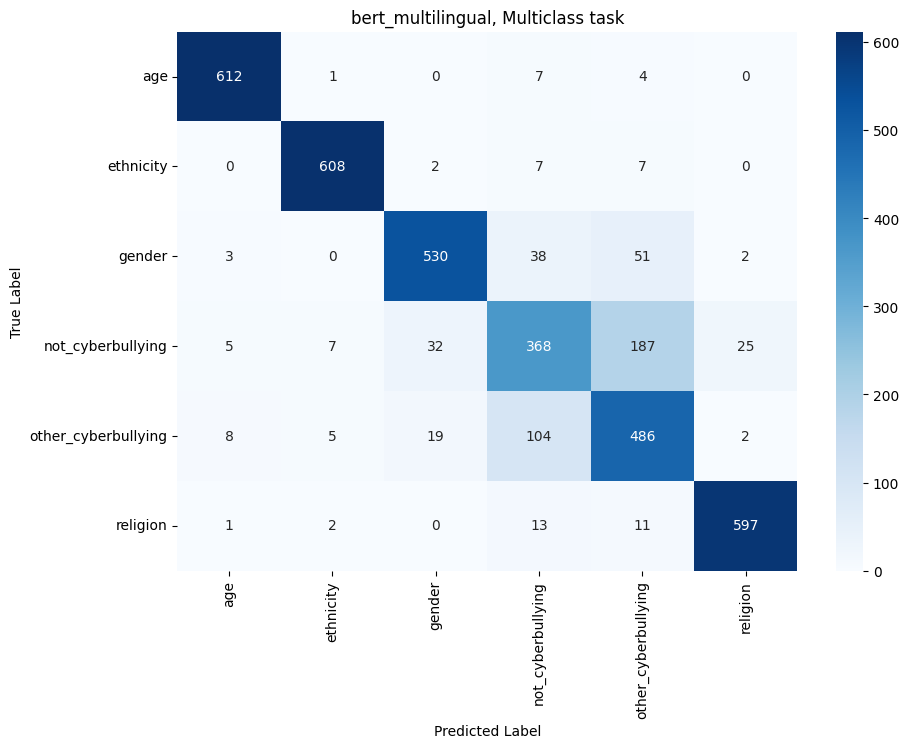

In [31]:
cm = confusion_matrix(y_test, bert_multi_preds)

cm_df = pd.DataFrame(cm, index=labels_name_multi, columns=labels_name_multi)

# Visualizza la matrice di confusione usando Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('bert_multilingual, Multiclass task')
plt.show()

<div style="font-size: 20px;">

Even with a multilanguage dataset, this model makes the **same errors** as the other transformers and has approximately the same accuracy. 

<br></div>

#### SAVING THE MODEL AND THE RESULTS

In [32]:
report_path = os.path.join(root_path, "outputs", "reports", "Bert Multilingual multiclass results")
bert_multi.save_results(dataloader_test, path = report_path, labels_name=labels_name_multi)

EVALUATION:: 100%|█████████████████████████████████████████████| 3744/3744 [00:07<00:00, 471.76it/s]

----------------------------------------------------------------------------------------------
| Report saved to /home/m.sanna21/V_HLT/outputs/reports/Bert Multilingual multiclass results |
----------------------------------------------------------------------------------------------


In [33]:
handler = ModelHandler(model_path)
handler.save_model(model = bert_multi, name= "bert_multilingual_multiclass")

----------------------------------------------------------------------------------------------------------------------
| Save model 'bert_multilingual_multiclass' to /home/m.sanna21/V_HLT/outputs/models/bert_multilingual_multiclass.pkl |
----------------------------------------------------------------------------------------------------------------------
